In [1]:
!pip3 install torch torchvision

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
                nn.ConvTranspose2d(channels_noise,features_g*32, kernel_size=4, stride=1, padding=0),
                nn.BatchNorm2d(features_g*32),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*32,features_g*16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*16),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*16,features_g*8, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*8),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*8,features_g*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*4),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*4,features_g*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*2),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*2,features_g, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g,channels_img, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
                nn.Conv2d(channels_img,features_d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d,features_d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*2),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*2,features_d*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*4),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*4,features_d*8, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*8),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*8,features_d*16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*16),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*16,features_d*32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*32),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*32, 1, kernel_size=4, stride=1, padding=0),
                nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


In [5]:
lr = 0.0002
batch_size = 16
image_size = 256
channels_img = 3
channels_noise = 256
num_epochs = 100
features_d = 32
features_g = 32

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
images = []
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/images'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))

In [7]:
x = Image.open(images[1])
x.mode

'RGB'

In [8]:
loaded_images = [Image.open(image).convert('RGB') for image in images[1:]]
real_images = [transform(image) for image in loaded_images]

In [9]:
real_images[0].shape

torch.Size([3, 256, 256])

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


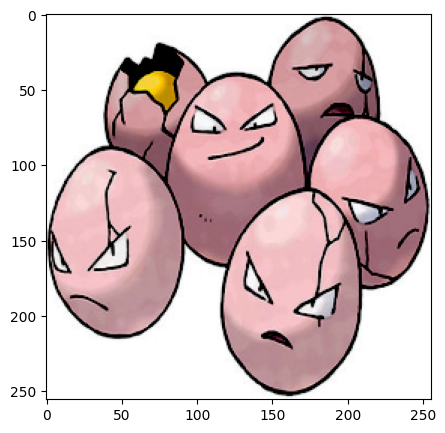

In [10]:
import random

x = real_images[random.randrange(0, len(real_images))]
print(x.shape)
reshaped_x = torch.reshape(x, (3, image_size, image_size))
print(x.shape)
plt.figure(figsize=(5, 5))
plt.imshow(reshaped_x.permute(1, 2, 0).numpy())  # permute to (height, width, channels) and convert to numpy array
#plt.title(name)
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [12]:
gen = Generator(channels_noise, channels_img, features_g)
gen = gen.to(device)
disc = Discriminator(channels_img, features_d)
disc = disc.to(device)

In [13]:
gen_optim = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optim = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

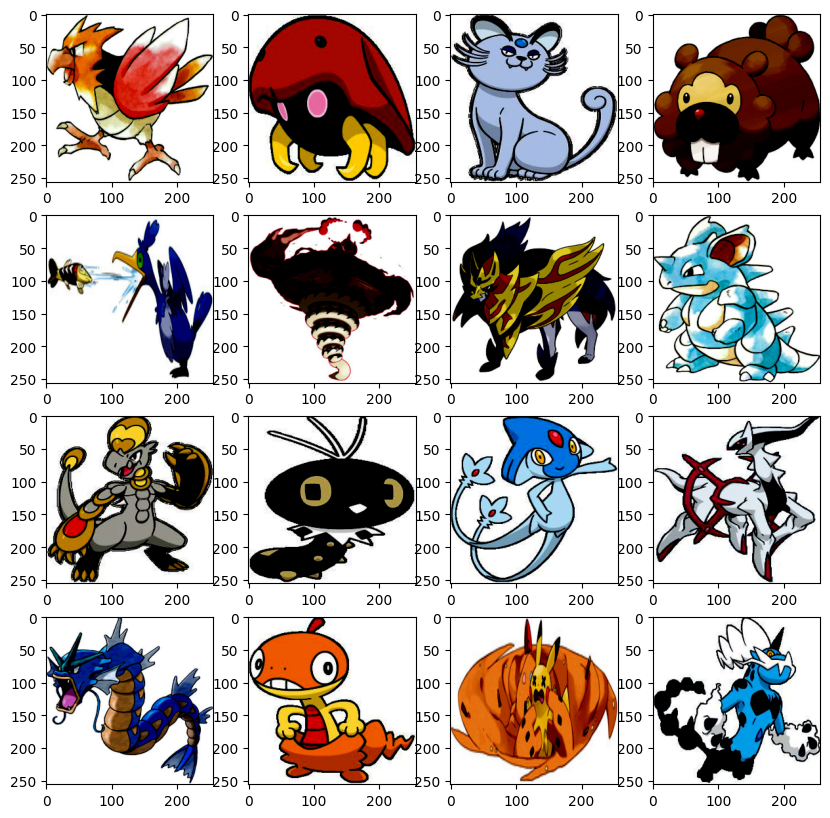

In [14]:
from torch.utils.data import DataLoader
dataloader = DataLoader(real_images, batch_size=batch_size, shuffle=True)
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
train_images = next(iter(dataloader))
plt.figure(figsize=(10, 10))
for i, image in enumerate(train_images):
    plt.subplot(4,4,i+1)
    plt.imshow(image.permute(1,2,0))

In [15]:
train_images.shape

torch.Size([16, 3, 256, 256])

In [16]:
print("Starting training...")

for epoch in range(num_epochs):
    for batch_index,images in enumerate(dataloader):
  #      print(device)
        images = images.to(device)
 #       print(images.dtype, images.device)
        batch_size = images.shape[0]
        ## Train Discriminator
        disc.zero_grad()
        labels = (torch.ones(batch_size)*0.9).to(device) # 1 for real images but set it to 0.9
        outputs = disc(images).reshape(-1) # classifiy real images
        loss_disc_real = criterion(outputs, labels) # loss on real images
        Disc_x = outputs.mean().item()

        noise = torch.randn(batch_size, channels_noise, 1,1).to(device)
        fake = gen(noise) # generate fake image from noise
        labels = (torch.ones(batch_size)*0.1).to(device) # 0 for fake images but set it to 0.1
        outputs = disc(fake.detach()).reshape(-1) # classifiy fake images, generate fake images and back prop
        loss_disc_fake = criterion(outputs, labels) # loss on fake images

        loss_disc = loss_disc_real + loss_disc_fake # total loss

        loss_disc.backward()
        disc_optim.step()


        ## Train Generator

        gen_optim.zero_grad()
        labels = torch.ones(batch_size).to(device)
        outputs = disc(fake).reshape(-1) # generate fake image with gradients and back prop
        loss_gen = criterion(outputs, labels)
        loss_gen.backward()
        gen_optim.step()

        if batch_index % 50 == 0:
            print(f"Epoch {epoch}/{num_epochs} Batch {batch_index}/{len(dataloader) } Loss Disc: {loss_disc:.4f} Loss gen: {loss_gen:.4f} Disc_X: {Disc_x:.4f}")

Starting training...
Epoch 0/100 Batch 0/157 Loss Disc: 1.4928 Loss gen: 9.6923 Disc_X: 0.4856
Epoch 0/100 Batch 50/157 Loss Disc: 1.0578 Loss gen: 5.8757 Disc_X: 0.9195
Epoch 0/100 Batch 100/157 Loss Disc: 0.7010 Loss gen: 3.0732 Disc_X: 0.8683
Epoch 0/100 Batch 150/157 Loss Disc: 0.7373 Loss gen: 2.7672 Disc_X: 0.9510
Epoch 1/100 Batch 0/157 Loss Disc: 0.9220 Loss gen: 6.2429 Disc_X: 0.8995
Epoch 1/100 Batch 50/157 Loss Disc: 0.8414 Loss gen: 5.4869 Disc_X: 0.8538
Epoch 1/100 Batch 100/157 Loss Disc: 0.6538 Loss gen: 2.3131 Disc_X: 0.8897
Epoch 1/100 Batch 150/157 Loss Disc: 0.6556 Loss gen: 2.3464 Disc_X: 0.8897
Epoch 2/100 Batch 0/157 Loss Disc: 0.6553 Loss gen: 2.2868 Disc_X: 0.8935
Epoch 2/100 Batch 50/157 Loss Disc: 0.6539 Loss gen: 2.2717 Disc_X: 0.9138
Epoch 2/100 Batch 100/157 Loss Disc: 0.7094 Loss gen: 4.6050 Disc_X: 0.8998
Epoch 2/100 Batch 150/157 Loss Disc: 0.7451 Loss gen: 2.2260 Disc_X: 0.7677
Epoch 3/100 Batch 0/157 Loss Disc: 0.6944 Loss gen: 2.1129 Disc_X: 0.8694
Ep

In [17]:
test_noise = torch.randn(8, channels_noise, 1,1 ).to(device)
outputs = gen(test_noise).squeeze()
outputs.shape

torch.Size([8, 3, 256, 256])

In [18]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
])
images = [transform_test(x) for x in outputs]

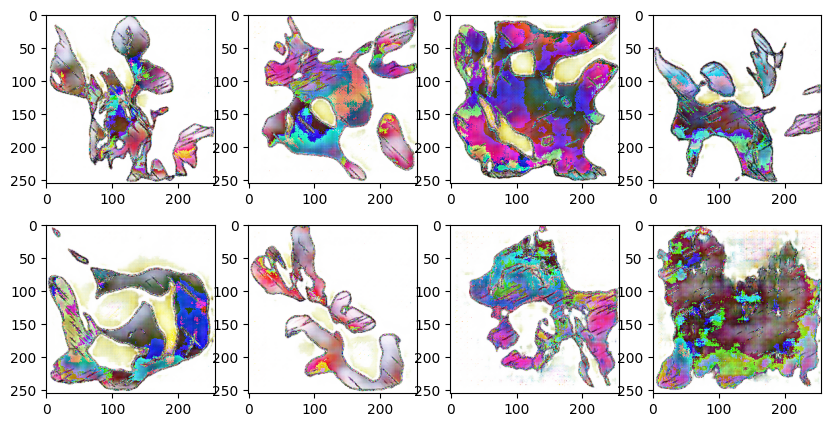

In [19]:
plt.figure(figsize=(10, 5))
for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
plt.show()